# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random


In [2]:

np.random.seed(2295528)

random.seed(2295528)

tf.random.set_seed(2295528)
K.clear_session()

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs,
              #verbose=0,
             verbose=1)
    return model

## 2 Clients

In [6]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5,random_state= 42)

In [7]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 11s 4ms/step - loss: 0.3422 - accuracy: 0.9039
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1599 - accuracy: 0.9532
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1123 - accuracy: 0.9677
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0834 - accuracy: 0.9748
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0630 - accuracy: 0.9823
Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 0.3451 - accuracy: 0.9020
Epoch 2/5
938/938 [==============================] - 2s 3ms/step - loss: 0.1639 - accuracy: 0.9530
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1149 - accuracy: 0.9662
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0837 - accuracy: 0.9752
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0638 - accuracy: 0.9814


In [8]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [9]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [10]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [11]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 2s - loss: 0.3376 - accuracy: 0.9238 - 2s/epoch - 7ms/step
Test accuracy: 0.923799991607666


In [12]:
test_accuracy = []

In [13]:
test_accuracy.append(test_acc)

In [14]:
test_accuracy

[0.923799991607666]

#### Write your code to calculate precision, recall, and F-score


In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 2s 5ms/step
(10000, 10)


In [17]:
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall:", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score:", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy: 0.9238
Precision: 0.9301122801328177
Recall: 0.9238
F-score: 0.924664971512951


In [18]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [19]:
test_precision.append(precision_score(y_test, predictions, average = 'weighted' ))
test_recall.append(recall_score(y_test, predictions, average = 'weighted' ))
test_f1_score.append(f1_score(y_test, predictions, average = 'weighted' ))

#### Display confusion matrix between actual and predicted values on the test data.


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

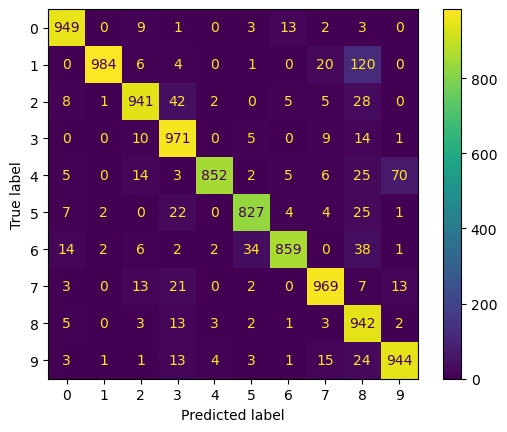

In [21]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

## Lab Logbook requirement: Document the

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

## Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

## 4 Clients

In [22]:
# Split data into 4 clients

In [23]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [24]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [25]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.4505 - accuracy: 0.8746
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2155 - accuracy: 0.9385
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.9576
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1130 - accuracy: 0.9694
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0851 - accuracy: 0.9779
Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 2.3142 - accuracy: 0.1023
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 2.2962 - accuracy: 0.1215
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 2.2870 - accuracy: 0.1294
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 2.2737 - accuracy: 0.1439
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 2.2535 - accuracy: 0.1620
Epoch 1/5


In [26]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights


In [27]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(),
                                               client2_model.get_weights(),
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [28]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 2.2269 - accuracy: 0.3613 - 788ms/epoch - 3ms/step
Test accuracy: 0.361299991607666


In [29]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [30]:
print("Accuracy: ", accuracy_score(y_test, predictions))

print("Precision: ", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score: ", f1_score(y_test, predictions, average = 'weighted' ))


Accuracy:  0.3613
Precision:  0.4373540240417135
Recall:  0.3613
F-score:  0.33704356635526345


In [31]:
test_accuracy.append(accuracy_score(y_test, predictions))
test_precision.append(precision_score(y_test, predictions, average = 'weighted' ))
test_recall.append(recall_score(y_test, predictions, average = 'weighted' ))
test_f1_score.append(f1_score(y_test, predictions, average = 'weighted' ))

In [32]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.923799991607666, 0.3613]
[0.9301122801328177, 0.4373540240417135]
[0.9238, 0.3613]
[0.924664971512951, 0.33704356635526345]


## 6 Clients

In [33]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [34]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 2s 3ms/step - loss: 0.5133 - accuracy: 0.8582
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2367 - accuracy: 0.9332
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1744 - accuracy: 0.9506
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1360 - accuracy: 0.9611
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1065 - accuracy: 0.9705
Epoch 1/5
313/313 [==============================] - 2s 3ms/step - loss: 2.3271 - accuracy: 0.1040
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2934 - accuracy: 0.1217
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2791 - accuracy: 0.1416
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2569 - accuracy: 0.1543
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2316 - accuracy: 0.1727
Epoch 1/5


In [35]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(),
                                               client2_model.get_weights(),
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [36]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy: ", accuracy_score(y_test, predictions))

print("Precision: ", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 2.0149 - accuracy: 0.5785 - 858ms/epoch - 3ms/step
Test accuracy: 0.578499972820282
313/313 [==============================] - 1s 2ms/step
(10000, 10)
Accuracy:  0.5785
Precision:  0.711910426069019
Recall:  0.5785
F-score:  0.5256294581541289
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       980
           1       0.98      0.04      0.09      1135
           2       0.58      0.75      0.65      1032
           3       0.47      0.93      0.62      1010
           4       0.91      0.49      0.64       982
           5       0.47      0.80      0.59       892
           6       0.81      0.60      0.69       958
           7       0.41      0.83      0.55      1028
           8       0.88      0.02      0.03       974
           9       0.77      0.52      0.62      1009

    accuracy                           0.58     10000
   macro avg       0.71      0.59      0.53     10000
weighted avg       0.71      0.

In [37]:
test_accuracy.append(accuracy_score(y_test, predictions))
test_precision.append(precision_score(y_test, predictions, average = 'weighted' ))
test_recall.append(recall_score(y_test, predictions, average = 'weighted' ))
test_f1_score.append(f1_score(y_test, predictions, average = 'weighted' ))

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.923799991607666, 0.3613, 0.5785]
[0.9301122801328177, 0.4373540240417135, 0.711910426069019]
[0.9238, 0.3613, 0.5785]
[0.924664971512951, 0.33704356635526345, 0.5256294581541289]


## 8 Clients

In [38]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 2s 3ms/step - loss: 0.5888 - accuracy: 0.8384
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.2536 - accuracy: 0.9297
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.1917 - accuracy: 0.9461
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1478 - accuracy: 0.9596
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1168 - accuracy: 0.9684
Epoch 1/5
235/235 [==============================] - 2s 4ms/step - loss: 2.3234 - accuracy: 0.1011
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: 2.2898 - accuracy: 0.1304
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 2.2715 - accuracy: 0.1464


In [39]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4,
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(),
                                               client2_model.get_weights(),
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [40]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy: ", accuracy_score(y_test, predictions))

print("Precision: ", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8255 - accuracy: 0.7152 - 800ms/epoch - 3ms/step
Test accuracy: 0.7152000069618225
313/313 [==============================] - 1s 3ms/step
(10000, 10)
Accuracy:  0.7152
Precision:  0.7993766687932204
Recall:  0.7152
F-score:  0.6976269237473771
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       980
           1       0.97      0.56      0.71      1135
           2       0.48      0.95      0.64      1032
           3       0.79      0.78      0.78      1010
           4       0.94      0.84      0.89       982
           5       0.62      0.73      0.67       892
           6       0.93      0.90      0.91       958
           7       0.52      0.93      0.66      1028
           8       0.95      0.15      0.26       974
           9       0.89      0.38      0.53      1009

    accuracy                           0.72     10000
   macro avg       0.80      0.72      0.70     10000
weighted avg       0.80      

In [41]:
test_accuracy.append(accuracy_score(y_test, predictions))
test_precision.append(precision_score(y_test, predictions, average = 'weighted' ))
test_recall.append(recall_score(y_test, predictions, average = 'weighted' ))
test_f1_score.append(f1_score(y_test, predictions, average = 'weighted' ))

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.923799991607666, 0.3613, 0.5785, 0.7152]
[0.9301122801328177, 0.4373540240417135, 0.711910426069019, 0.7993766687932204]
[0.9238, 0.3613, 0.5785, 0.7152]
[0.924664971512951, 0.33704356635526345, 0.5256294581541289, 0.6976269237473771]


## 10 Clients

In [42]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 2s 3ms/step - loss: 0.6346 - accuracy: 0.8302
Epoch 2/5
188/188 [==============================] - 1s 3ms/step - loss: 0.2666 - accuracy: 0.9313
Epoch 3/5
188/188 [==============================] - 1s 3ms/step - loss: 0.1952 - accuracy: 0.9463
Epoch 4/5
188/188 [==============================] - 1s 3ms/step - loss: 0.1528 - accuracy: 0.9588
Epoch 5/5
188/188 [==============================] - 1s 3ms/step - loss: 0.1201 - accuracy: 0.9702
Epoch 1/5
188/188 [==============================] - 1s 4ms/step - loss: 2.3324 - accuracy: 0.1005
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 2.2843 - accuracy: 0.1295
Epoch 3/5
188/188 [============================

In [43]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4,
                                                      weights5, weights6, weights7, weights8,
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(),
                                               client2_model.get_weights(),
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [44]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy: ", accuracy_score(y_test, predictions))

print("Precision: ", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8185 - accuracy: 0.6156 - 760ms/epoch - 2ms/step
Test accuracy: 0.6155999898910522
313/313 [==============================] - 1s 2ms/step
(10000, 10)
Accuracy:  0.6156
Precision:  0.8012185669772623
Recall:  0.6156
F-score:  0.5919453723869428
              precision    recall  f1-score   support

           0       0.99      0.36      0.53       980
           1       0.98      0.84      0.90      1135
           2       0.61      0.92      0.73      1032
           3       0.96      0.57      0.72      1010
           4       0.92      0.78      0.85       982
           5       0.40      0.80      0.54       892
           6       0.97      0.72      0.83       958
           7       0.33      0.97      0.49      1028
           8       0.98      0.10      0.19       974
           9       0.84      0.06      0.11      1009

    accuracy                           0.62     10000
   macro avg       0.80      0.61      0.59     10000
weighted avg       0.80      

In [45]:
test_accuracy.append(accuracy_score(y_test, predictions))
test_precision.append(precision_score(y_test, predictions, average = 'weighted' ))
test_recall.append(recall_score(y_test, predictions, average = 'weighted' ))
test_f1_score.append(f1_score(y_test, predictions, average = 'weighted' ))

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.923799991607666, 0.3613, 0.5785, 0.7152, 0.6156]
[0.9301122801328177, 0.4373540240417135, 0.711910426069019, 0.7993766687932204, 0.8012185669772623]
[0.9238, 0.3613, 0.5785, 0.7152, 0.6156]
[0.924664971512951, 0.33704356635526345, 0.5256294581541289, 0.6976269237473771, 0.5919453723869428]


### Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

In [46]:
import pandas as pd

In [47]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.923799991607666, 0.3613, 0.5785, 0.7152, 0.6156], [0.9301122801328177, 0.4373540240417135, 0.711910426069019, 0.7993766687932204, 0.8012185669772623], [0.9238, 0.3613, 0.5785, 0.7152, 0.6156], [0.924664971512951, 0.33704356635526345, 0.5256294581541289, 0.6976269237473771, 0.5919453723869428]]


,Accuracy,Precision,Recall,F1_Score
2,0.9238,0.930112,0.9238,0.924665
4,0.3613,0.437354,0.3613,0.337044
6,0.5785,0.711910,0.5785,0.525629
8,0.7152,0.799377,0.7152,0.697627
10,0.6156,0.801219,0.6156,0.591945


<Axes: >

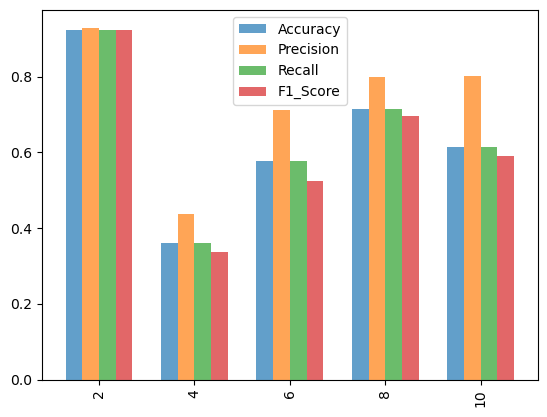

In [48]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

### 2.For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

#### Take 6 Clients, one of them is assumed dishonest



In [49]:
# Split data into 6 clients

In [50]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [51]:
Client_4[1].size

10000

In [52]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [53]:
### Client_2 is assumed dishonest and changing the training data. Some labels are set as 4
### Change the first 2000 labels

Client_4[1][:2000] = 3

In [54]:
Client_4[1]

array([3, 3, 3, ..., 9, 9, 5], dtype=uint8)

In [55]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [56]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 3s 5ms/step - loss: 0.5268 - accuracy: 0.8578
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 0.2380 - accuracy: 0.9325
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1740 - accuracy: 0.9514
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1355 - accuracy: 0.9609
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1039 - accuracy: 0.9713
Epoch 1/5
313/313 [==============================] - 2s 3ms/step - loss: 2.3189 - accuracy: 0.1045
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2935 - accuracy: 0.1228
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 2.2780 - accuracy: 0.1432
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 2.2582 - accuracy: 0.1555
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 2.2310 - accuracy: 0.1772
Epoch 1/5


In [57]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(),
                                               client2_model.get_weights(),
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [58]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy: ", accuracy_score(y_test, predictions))

print("Precision: ", precision_score(y_test, predictions, average = 'weighted' ))
print("Recall: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 2.0121 - accuracy: 0.7772 - 747ms/epoch - 2ms/step
Test accuracy: 0.7771999835968018
313/313 [==============================] - 1s 2ms/step
(10000, 10)
Accuracy:  0.7772
Precision:  0.7920064781019767
Recall:  0.7772
F-score:  0.7759029175417168
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       980
           1       0.90      0.91      0.91      1135
           2       0.74      0.75      0.74      1032
           3       0.55      0.83      0.66      1010
           4       0.77      0.93      0.84       982
           5       0.74      0.79      0.76       892
           6       0.92      0.83      0.87       958
           7       0.85      0.75      0.80      1028
           8       0.79      0.48      0.60       974
           9       0.81      0.65      0.72      1009

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.77     10000
weighted avg       0.79      

In [59]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [60]:
test_accuracy_dishonest.append(test_accuracy[4])
test_precision_dishonest.append(test_precision[4])
test_recall_dishonest.append(test_recall[4])
test_f1_score_dishonest.append(test_f1_score[4])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.6156, 0.7197999954223633]
[0.8012185669772623, 0.7649681801937827]
[0.6156, 0.7198]
[0.5919453723869428, 0.7079021148713025]


In [61]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Every input is honest', 'Client 4 is honest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.6156, 0.7197999954223633], [0.8012185669772623, 0.7649681801937827], [0.6156, 0.7198], [0.5919453723869428, 0.7079021148713025]]


,Accuracy,Precision,Recall,F1_Score
Every input is honest,0.6156,0.801219,0.6156,0.591945
Client 4 is honest,0.7198,0.764968,0.7198,0.707902


<Axes: >

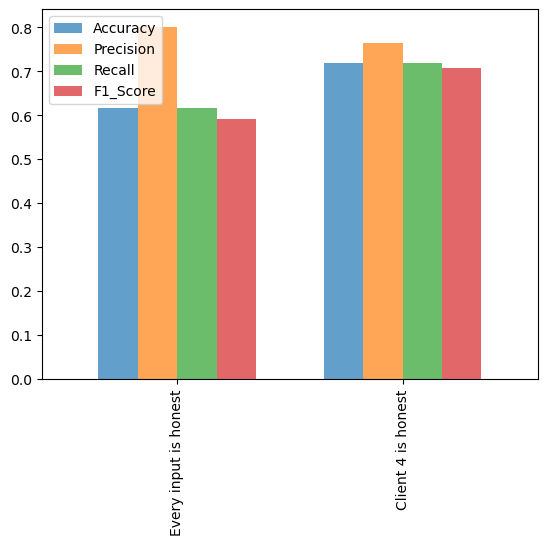

In [62]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)